In [34]:
import gymnasium as gym
import time
import pygame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

# from algorithms.rl import RL
# from examples.test_env import TestEnv
from algorithms.planner import Planner

In [35]:
T,R = mdptoolbox.example.forest(S=400)

In [32]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=10000):
    start_time = time.time()
    
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'policy', 'mean_rewards', 'max_rewards', 'error']
    results = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)

    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            
            results['gamma'][testNum]        = g
            results['epsilon'][testNum]      = e
            results['time'][testNum]         = Time
            results['iterations'][testNum]   = iters
            results['reward'][testNum]       = maxR
            results['mean_rewards'][testNum] = {tuple(mean_rewards)}
            results['max_rewards'][testNum]  = {tuple(max_rewards)}
            results['error'][testNum]        = {tuple(errors)}
            results['policy'][testNum]       = {test.policy}
                        
            testNum += 1
        
    print('Time taken: ' + str(time.time() - start_time))
    
    results.fillna(0, inplace=True)
    results.head()
        
    return results

In [ ]:
gammas   = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
epsilons = [1e-2, 1e-3, 1e-8, 1e-12]
vi_results  = valueIteration(T, R, gammas, epsilons, showResults=False)

<Axes: title={'center': 'FM PI Reward vs. Iterations'}, xlabel='reward'>

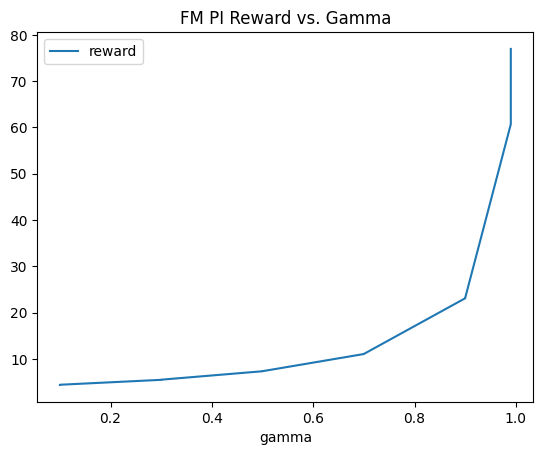

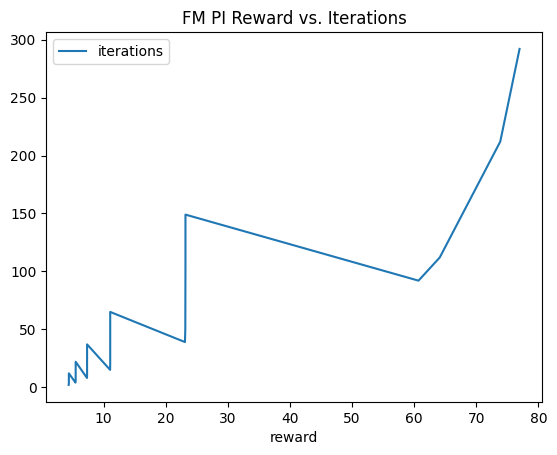

In [22]:

vi_results.plot(x='gamma', y='reward', title="FM PI Reward vs. Gamma")
vi_results.plot(x='reward', y='iterations', title="FM PI Reward vs. Iterations")


In [23]:
# find the highest score
bestRun = vi_results['reward'].argmax()
bestPolicy = vi_results['policy'][bestRun]
print('best Reward = ' + str(vi_results['reward'].max()))
print('best Gamma = ' + str(vi_results['gamma'].max()))
print('best Epsilon = ' + str(vi_results['epsilon'].max()))


best Reward = 76.97495085837569
best Gamma = 0.99
best Epsilon = 0.01


Policy Iteration

In [24]:
def policyIteration(t, r, gammas, max_iterations=100000):
    t0 = time.time()
    
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    results = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix")
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        results['gamma'][testnum]        = g
        results['time'][testnum]         = Time
        results['iterations'][testnum]   = iters
        results['reward'][testnum]       = maxr
        results['mean_rewards'][testnum] = {tuple(mean_rewards)}
        results['max_rewards'][testnum]  = {tuple(max_rewards)}
        results['error'][testnum]        = {tuple(errors)}
        results['policy'][testnum]       = {test.policy}
        
        testnum = testnum + 1
        
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    results.fillna(0, inplace=True)
    results.head()
        
    return results

In [ ]:
gamma_iter   = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
pi_results  = policyIteration(T, R, gamma_iter)

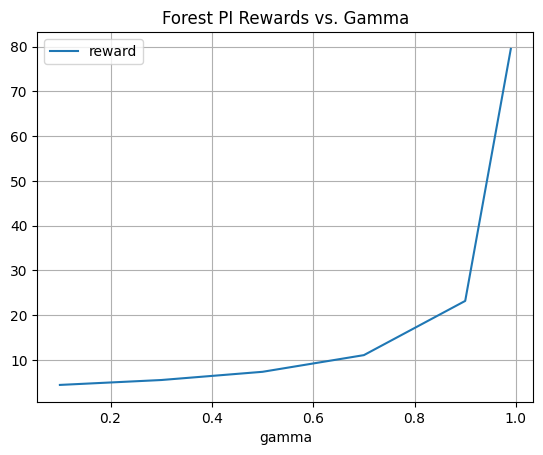

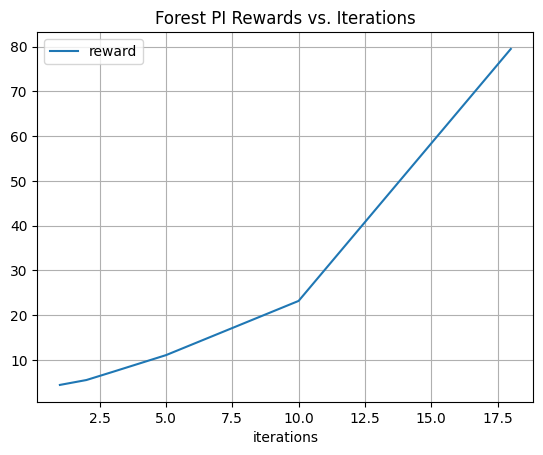

In [26]:
pi_results.plot(x='gamma', y='reward', title='Forest PI Rewards vs. Gamma')
plt.grid()

pi_results.plot(x='iterations', y='reward', title='Forest PI Rewards vs. Iterations')
plt.grid()

Q-Learning

In [27]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):

    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    results = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)

    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        results['gamma'][testNum]         = g
                        results['alpha'][testNum]         = a
                        results['alpha_decay'][testNum]   = a_decay
                        results['epsilon_decay'][testNum] = e_decay
                        results['time'][testNum]          = time
                        results['iterations'][testNum]    = iters
                        results['reward'][testNum]        = maxR
                        results['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        results['max_rewards'][testNum]   = {tuple(max_rewards)}
                        results['error'][testNum]         = {tuple(errors)}
                        results['policy'][testNum]        = {test.policy}

                        testNum += 1
                        
    results.fillna(0, inplace=True)
    results.head()
        
    return results

In [ ]:
gammas = [0.99]
alphas = [0.01, 0.1]
alpha_decays = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations = [10000, 50000]

ql_results  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)


In [29]:
# Look at correlation matrix
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'reward', 'time']

# pick out hyperparameters and how succesful they were
df = ql_results[interest]

# See what affected the success_pct the most
ql_corr = df.corr()

def plot_QL(dependent, independent, title=None, logscale=False):
    if dependent not in interest:
        print('Dependent variable not available')
        return
    if independent not in interest:
        print('Independent variable not available')
        return
    
    x = np.unique(df[dependent])
    y = []
    
    for i in x:
        y.append(df.loc[df[dependent] == i][independent].mean())
        
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-')
    
    if title == None:
        title = independent + ' vs. ' + dependent
    plt.title(title, fontsize=15)
    plt.xlabel(dependent)
    plt.ylabel(independent)
    plt.grid(True)
    if logscale:
        plt.xscale('log')
    
    title='QL_' + independent + '_vs_' + dependent

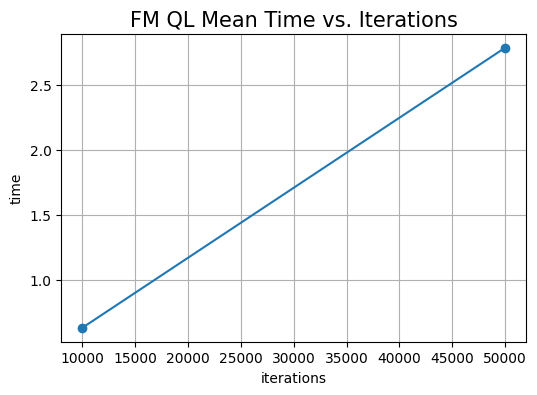

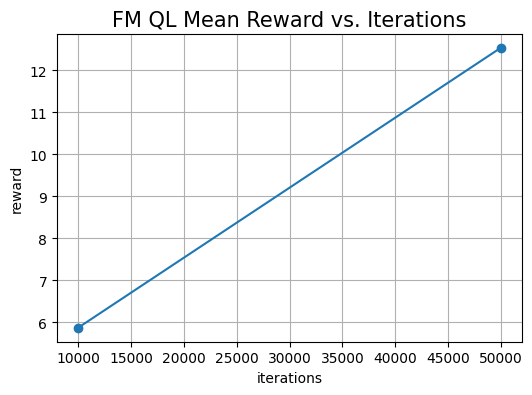

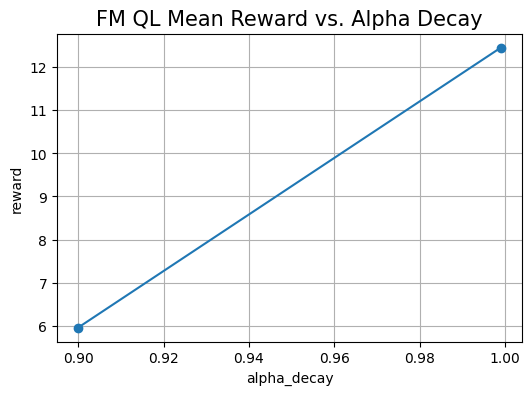

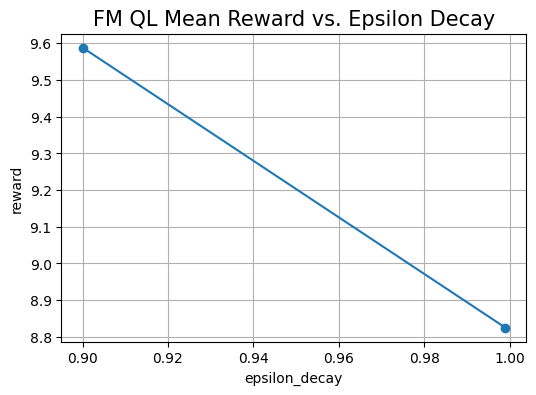

In [30]:
plot_QL('iterations', 'time', title='FM QL Mean Time vs. Iterations')
plot_QL('iterations', 'reward', title='FM QL Mean Reward vs. Iterations')
plot_QL('alpha_decay', 'reward', title='FM QL Mean Reward vs. Alpha Decay')
plot_QL('epsilon_decay', 'reward', title='FM QL Mean Reward vs. Epsilon Decay')
